In [22]:
import numpy as np
import cv2
from matplotlib import pyplot as plt


vidcap = cv2.VideoCapture('world.mp4')
success, frame = vidcap.read()

video_fps = vidcap.get(cv2.CAP_PROP_FPS)
total_frames = vidcap.get(cv2.CAP_PROP_FRAME_COUNT)
height = int(vidcap.get(cv2.CAP_PROP_FRAME_HEIGHT))
width = int(vidcap.get(cv2.CAP_PROP_FRAME_WIDTH))

vidcap.set(cv2.CAP_PROP_POS_FRAMES, 100)
succes, frame2 = vidcap.read()

In [23]:
MIN_MATCH_COUNT = 10
img1 = frame
img2 = cv2.imread('panorama.png')

# Initiate SIFT detector
sift = cv2.SIFT_create()

# find the keypoints and descriptors with SIFT
kp1, des1 = sift.detectAndCompute(img1, None)
kp2, des2 = sift.detectAndCompute(img2, None)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks = 50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1,des2,k=2)

# store all the good matches as per Lowe's ratio test.
good = []
for m,n in matches:
    if m.distance < 0.7*n.distance:
        good.append(m)

In [24]:
if len(good)>MIN_MATCH_COUNT:
    src_pts = np.float32([ kp1[m.queryIdx].pt for m in good ]).reshape(-1,1,2)
    dst_pts = np.float32([ kp2[m.trainIdx].pt for m in good ]).reshape(-1,1,2)

    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC,5.0)
    matchesMask = mask.ravel().tolist()
    
    h,w,c = img1.shape
    pts = np.float32([ [0,0],[0,h-1],[w-1,h-1],[w-1,0] ]).reshape(-1,1,2)
    dst = cv2.perspectiveTransform(pts,M)
    img2 = cv2.polylines(img2,[np.int32(dst)],True,255,3, cv2.LINE_AA)

else:
    print( "Not enough matches are found - {}/{}".format(len(good), MIN_MATCH_COUNT) )
    matchesMask = None

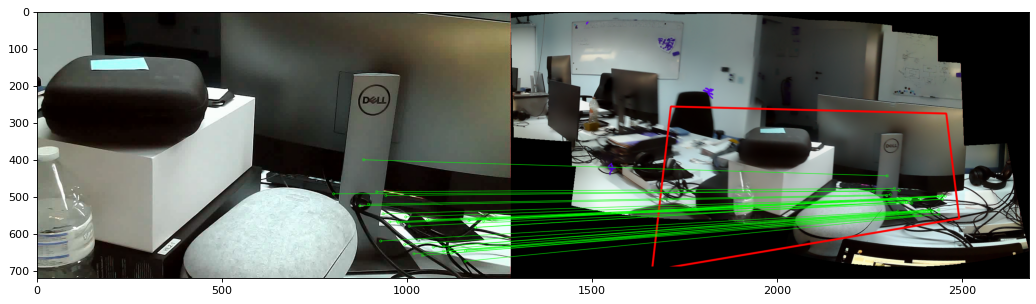

In [25]:
draw_params = dict(matchColor = (0,255,0), # draw matches in green color
                   singlePointColor = None,
                   matchesMask = matchesMask, # draw only inliers
                   flags = 2)
                   
img3 = cv2.drawMatches(img1,kp1,img2,kp2,good,None,**draw_params)

plt.figure(figsize=(16, 6), dpi=80)
plt.imshow(img3)
plt.show()

In [26]:
M

array([[ 1.04010376e+00, -1.36256805e-01,  4.32294526e+02],
       [ 1.22312156e-01,  4.94279565e-01,  2.57403042e+02],
       [ 3.89039704e-04, -1.72306323e-04,  1.00000000e+00]])

In [27]:
img2.shape[1] + img1.shape[1]

2680